# MNIST classification problem-Support Vector MAchine classifier

## Import basic libraries

In [1]:
#@title [Imports]
import numpy as np
import pandas as pd
from pprint import pprint
import os
import io
import warnings

#to amke this notebook's output stable across runs
np.random.seed(42)

#sklearn specific imports
from keras.datasets import mnist
from sklearn.svm import SVC
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedShuffleSplit

#scipy
from scipy.stats import loguniform

#To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

# #global settings
# mpl.rc('axes',labelsize=14)
# mpl.rc('xtick',labelsize=12)
# mpl.rc('ytick',labelsize=12)
# mpl.rc('figure',figsize=(8,6))

## Loading MNIST Dataset

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
print('Shape of training data',X_train.shape)
print('Shape of training labels',y_train.shape)
print('Shape of test data',X_test.shape)
print('Shape of test labels',y_test.shape)

Shape of training data (60000, 28, 28)
Shape of training labels (60000,)
Shape of test data (10000, 28, 28)
Shape of test labels (10000,)


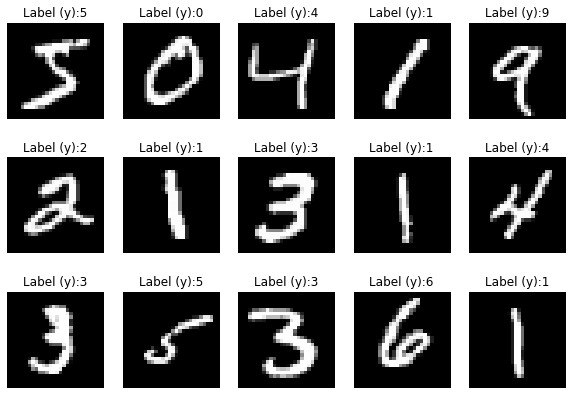

In [4]:
#Plotting data samples
fig=plt.figure(figsize=(10,7))
for i in range(15):
  ax=fig.add_subplot(3,5,i+1)
  ax.imshow(X_train[i],cmap=plt.get_cmap('gray'))
  ax.set_title('Label (y):{y}'.format(y=y_train[i]))
  plt.axis('off')

In [5]:
#Flatten each input image into a vector of length 784
X_train = X_train.reshape(X_train.shape[0],28*28)
X_test = X_test.reshape(X_test.shape[0],28*28)

#Normalizing
X_train=X_train/255
X_test=X_test/255

In [6]:
X_train.shape

(60000, 784)

In [7]:
X_test.shape

(10000, 784)

In [8]:
X_train=X_train[:10000,:]
y_train=y_train[:10000]
X_test = X_test[:2000,:]
y_test =y_test[:2000]

## Linear SVM for MNIST multiclass classification

### Using Pipeline

In [9]:
pipe_1 = Pipeline([('scaler',MinMaxScaler()),('classifer',SVC(kernel='linear',C=1))])
pipe_1.fit(X_train,y_train.ravel())

#Evaluate the model using crossvalidation
acc = cross_val_score(pipe_1,X_train,y_train.ravel(),cv=2)
print("Training accuracy:{:.2f}%".format(acc.mean()*100))

Training accuracy:91.07%


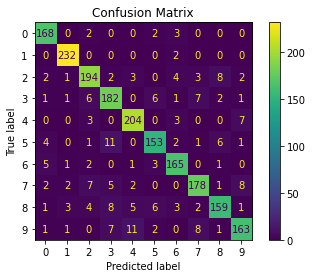

In [10]:
#visualizing confusion matrix
y_pred = pipe_1.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [11]:
CR=classification_report(y_test,y_pred)
print(CR)

              precision    recall  f1-score   support

           0       0.91      0.96      0.94       175
           1       0.96      0.99      0.98       234
           2       0.89      0.89      0.89       219
           3       0.85      0.88      0.86       207
           4       0.90      0.94      0.92       217
           5       0.89      0.85      0.87       179
           6       0.90      0.93      0.91       178
           7       0.89      0.87      0.88       205
           8       0.89      0.83      0.86       192
           9       0.89      0.84      0.86       194

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



## Non-linear SVM for MNIST

### Using Pipeline

In [12]:
pipe_2 = Pipeline([('scaler',MinMaxScaler()),('classifer',SVC(kernel='rbf',C=1,gamma=0.1))])
pipe_2.fit(X_train,y_train.ravel())

#Evaluate the model using crossvalidation
acc = cross_val_score(pipe_2,X_train,y_train.ravel(),cv=2)
print("Training accuracy:{:.2f}%".format(acc.mean()*100))

Training accuracy:82.87%


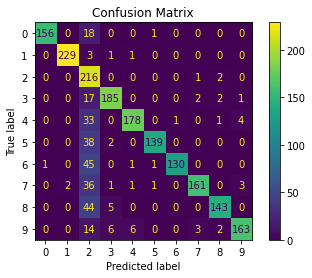

In [13]:
#visualizing confusion matrix
y_pred = pipe_2.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [14]:
CR=classification_report(y_test,y_pred)
print(CR)

              precision    recall  f1-score   support

           0       0.99      0.89      0.94       175
           1       0.99      0.98      0.98       234
           2       0.47      0.99      0.63       219
           3       0.93      0.89      0.91       207
           4       0.95      0.82      0.88       217
           5       0.98      0.78      0.87       179
           6       0.99      0.73      0.84       178
           7       0.96      0.79      0.87       205
           8       0.95      0.74      0.84       192
           9       0.95      0.84      0.89       194

    accuracy                           0.85      2000
   macro avg       0.92      0.84      0.86      2000
weighted avg       0.91      0.85      0.86      2000



### Using GridSearchCV
We can use a grid search cross-validation to explore combinations of parameters. Here we will adjust C(which controls the margin hardness) and `gamma`(which controls the size of the radial basis function kernel) and determine the best model

In [ ]:
scaler=StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

C_range=np.logspace(-2,10,13)
gamma_range=np.logspace(-9,3,13)
param_grid = dict(gamma=gamma_range,C=C_range)
cv=StratifiedShuffleSplit(n_splits=3,test_size=0.2, random_state=42)
grid=GridSearchCV(SVC(kernel='rbf'),param_grid=param_grid,cv=cv)
grid.fit(X_train, y_train.ravel())
print("the best parameters are %s with a score of %0.2f".format(grid.best_params_,grid.best_score_))

In [ ]:
#visualizing confusion matrix
y_pred = grid.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()